In [1]:
from time import perf_counter
import os
from joblib import Parallel, delayed
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

from src import utils
from src import models

SEED = 10
N_CPUS = os.cpu_count()
SAVE = False
SAVE_CSV = False
DECIMATE = 10
PATH = './results/update/update'

np.random.seed(SEED)

In [2]:
def run_experiment(g, Exps, graph_p, signal_p, def_args, verb=True):
    Adj_list = utils.create_dinamic_graph(**graph_p)
    X_list, _ = utils.create_dinamic_gmrf_signals(Adj_list, **signal_p)
    n_nodes = Adj_list[-1].shape[0]
    n_samples = np.array( [X_i.shape[1] for X_i in X_list] ).sum()

    Adjs_off = None
    err_seq = np.zeros((n_samples, len(Exps)))
    runtime = np.zeros(len(Exps))
    err_wrt_off = np.zeros((n_samples, len(Exps)))
    regret = np.zeros((n_samples, len(Exps)))
    for i, exp in enumerate(Exps):
        args_aux = {**def_args, **exp['args']} if 'args' in exp.keys() else {**def_args}
        args_aux['lamb'] = utils.lamb_value(n_nodes, n_samples, args_aux['lamb'])
        model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
        t_init = perf_counter()
        model.fit(X_list, **args_aux)
        t_end = perf_counter()

        if i == 0:
            Adjs_off = model.S_seq.copy()

        err_seq[:,i] = model.test_sequence_err(Adj_list)
        runtime[i] = t_end - t_init
        err_wrt_off[:,i], regret[:,i] = model.regret(Adjs_off)
        err_graph_aux = model.test_err(Adj_list)

        if verb and g % N_CPUS == 0:
            print(f'- {g+1}. {exp["leg"]}: Err last graph: {err_graph_aux[-1]:.3f}  -  Err last graph off: {err_wrt_off[-1,i]:.3f}  ' +\
                  f'-   time: {runtime[i]:.3f} secs')            
    
    return err_seq, runtime, err_wrt_off, regret


# Update vs Graph Size

In [3]:
# Common parameters
n_graphs = 50
verb = True
COLD_START = False
OFFLINE_ITERS = 100
OFF_UPDATE = 'incr'

graph_p = {
    'graph_type': 'er',
    'edge_type': 'positive',
    'new_edges': 4,
    'new_nodes': [15]*2,
    'load_adjs_fact': .1,  # 01
    'conn_nodes': True,
}

signal_p = {
    'samples_t': 500,
    'noise_power': .05,
}

default_args = {
    'iters_sample': 1,
    'lamb': .5,
    'stepsize': 1e-3,  # 1e-3,
    'gamma': .99, 
    'epsilon': 1,
    'alpha': 0,
}

In [4]:
N = 100
graph_p['n_nodes'] = N
graph_p['edges'] = N*4
signal_p['samples_t'] = [300]*2 + [400]

Exps_small = [
    {'model': models.Online_dyn_nti, 'init': {'cov_update': OFF_UPDATE}, 'leg': f'Off', 'fmt': '-',
     'args': {'iters_sample': OFFLINE_ITERS, 'cold_start': COLD_START}},

    # Online and batch
    {'model': models.Offline_dyn_nti, 'args': {'iters_sample': 1,}, 'leg': f'Batch', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'leg': f'Exp', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'leg': f'Dyn', 'fmt': '-'},
    # {'model': models.Online_dyn_nti, 'init': {'cov_update': 'stationary'}, 'leg': f'Sta', 'fmt': '-'},
]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_experiment)(g, Exps_small, graph_p, signal_p, default_args, verb) for g in range(n_graphs))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

err_seq_small, runtime_small, err_off_small, regret_small = zip(*results)

CPUs employed: 64
- 1. Off: Err last graph: 0.119  -  Err last graph off: 0.000  -   time: 83.208 secs
- 1. Batch: Err last graph: 0.229  -  Err last graph off: 0.168  -   time: 0.604 secs
- 1. Exp: Err last graph: 0.231  -  Err last graph off: 0.176  -   time: 0.654 secs
- 1. Dyn: Err last graph: 0.285  -  Err last graph off: 0.231  -   time: 0.617 secs
----- Solved in 1.516 minutes -----


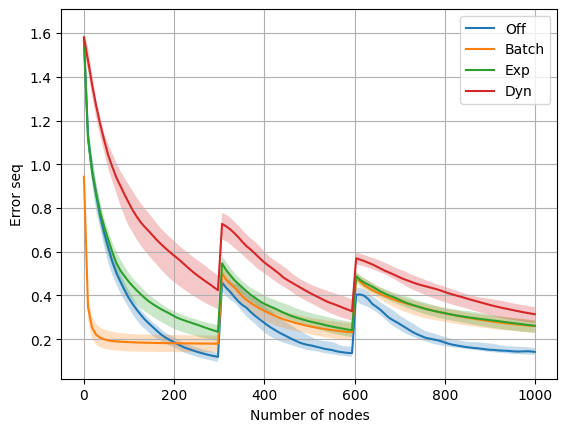

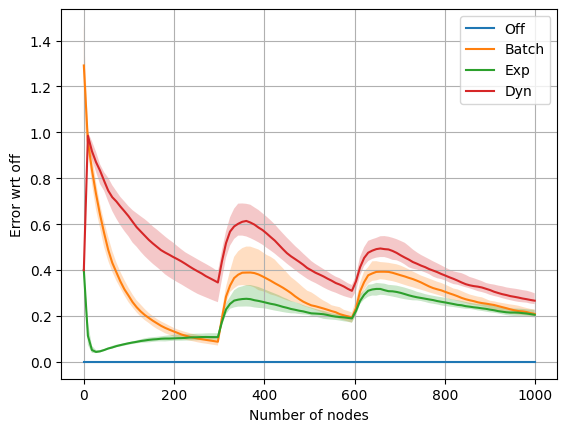

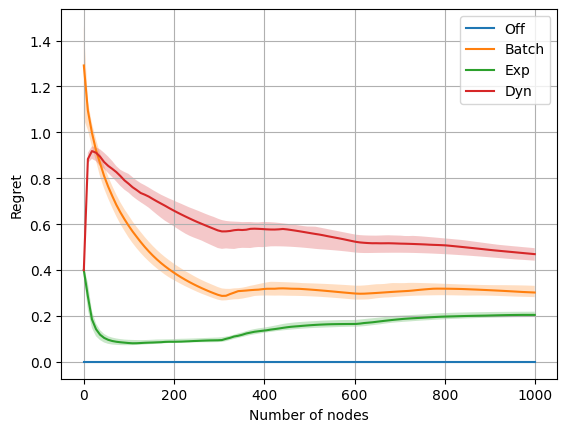

In [5]:
fig, axes = plt.subplots()
utils.plot_data(axes, err_seq_small, Exps_small, np.arange(err_seq_small[0].shape[0]), 'Number of nodes', 'Error seq',
                    agg='median', deviation='prctile', dec=DECIMATE)

fig, axes = plt.subplots()
utils.plot_data(axes, err_off_small, Exps_small, np.arange(err_off_small[0].shape[0]), 'Number of nodes', 'Error wrt off',
                    agg='median', deviation='prctile', dec=DECIMATE)
fig, axes = plt.subplots()
utils.plot_data(axes, regret_small, Exps_small, np.arange(regret_small[0].shape[0]), 'Number of nodes', 'Regret',
                    agg='median', deviation='prctile', dec=DECIMATE)

In [6]:
if SAVE:
    err_dict = {'err_seq': err_seq_small, 'runtime': runtime_small, 'err_off': err_off_small,
                'regret': regret_small}
    file_name = PATH + f'_{N}'
    utils.save_data(file_name, Exps_small, err_dict, agg='median', save_csv=SAVE_CSV, dec=DECIMATE)